In [269]:
import pandas as pd
import seaborn as sns
import random
import itertools
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [146]:
np.random.geometric(.5)

5

In [196]:
POP_SIZE = 10
UPDATES = 100
GENOME_LENGTH = 5

#data = pd.DataFrame()


pop = []
for _ in range(POP_SIZE):
    pop.append(tuple([np.random.geometric(.5) for i in range(GENOME_LENGTH)]))


In [84]:
def lexicase_fitness(orgs):
    fitnesses = {org:0.0 for org in orgs}
    for order in itertools.permutations(range(len(orgs[0]))):
        remaining = orgs[:]
        for axis in order:
            best = 0
            winners = []
            for i in range(len(remaining)):
                if remaining[i][axis] > remaining[best][axis]:
                    best = i
                    winners = [remaining[i]]
                elif remaining[i][axis] == remaining[best][axis]:
                    winners.append(remaining[i])
            remaining = winners
            if len(remaining) == 1:
                break
        for org in remaining:
            fitnesses[org] += 1.0/len(remaining)
    
    for org in orgs:
        fitnesses[org] /= math.factorial(len(orgs[0]))
        
    return fitnesses

In [51]:
lexicase_fitness(pop)

{(0, 0, 1, 5): 0.0,
 (0, 5, 2, 1): 0.25,
 (1, 4, 4, 0): 0.0,
 (2, 0, 2, 5): 0.0,
 (2, 0, 5, 3): 0.25,
 (2, 2, 3, 0): 0.0,
 (3, 2, 0, 1): 0.0,
 (4, 2, 4, 5): 0.25,
 (5, 2, 4, 1): 0.08333333333333333,
 (5, 4, 3, 2): 0.16666666666666666}

In [206]:
def eco_ea_fitness(orgs):
    fitnesses = {org:1.0 for org in orgs}
    rel_fitnesses = {org:0.0 for org in orgs}
    
    for axis in range(len(orgs[0])):
        res = 2000
        count = 0
        for org in orgs:
            if org[axis] >= 3:
                count += 1
        res /= count
        for org in orgs:
            if org[axis] >= 3:
                fitnesses[org] *= 2**((.0025*res*(org[axis]/5.0)**2) - 1)
                #print(axis, org, 2**((.0025*res*(org[axis]/5.0)**2) - 1))
                
    for org in orgs:
        wins = 0
        ties = -1 #org will tie with itself
        fit = fitnesses[org]
        for val in fitnesses.values():
            if fit > val:
                wins += 1
            elif fit == val:
                ties += 1
        rel_fitnesses[org] = (2/len(orgs)) * (wins/(len(orgs) - 1) + .5*ties/(len(orgs) - 1))
        
    return rel_fitnesses
        
        

In [198]:
eco_ea_fitness(pop)

500.0
0 (3, 1, 1, 3, 5) 0.6830201283771977
0 (4, 3, 2, 1, 5) 0.8705505632961242
0 (5, 1, 2, 5, 2) 1.189207115002721
0 (3, 1, 2, 3, 4) 0.6830201283771977
666.6666666666666
1 (1, 6, 2, 1, 1) 2.6390158215457884
1 (4, 3, 2, 1, 5) 0.757858283255199
1 (1, 5, 4, 4, 1) 1.5874010519681994
666.6666666666666
2 (1, 1, 4, 2, 1) 1.047294122820627
2 (1, 5, 4, 4, 1) 1.047294122820627
2 (1, 1, 3, 1, 1) 0.757858283255199
500.0
3 (3, 1, 1, 3, 5) 0.6830201283771977
3 (1, 5, 4, 4, 1) 0.8705505632961242
3 (5, 1, 2, 5, 2) 1.189207115002721
3 (3, 1, 2, 3, 4) 0.6830201283771977
500.0
4 (2, 2, 1, 1, 3) 0.6830201283771977
4 (3, 1, 1, 3, 5) 1.189207115002721
4 (4, 3, 2, 1, 5) 1.189207115002721
4 (3, 1, 2, 3, 4) 0.8705505632961242


{(1, 1, 3, 1, 1): 0.06666666666666667,
 (1, 1, 4, 2, 1): 0.13333333333333333,
 (1, 5, 4, 4, 1): 0.17777777777777778,
 (1, 6, 2, 1, 1): 0.2,
 (2, 1, 1, 1, 1): 0.11111111111111112,
 (2, 2, 1, 1, 3): 0.044444444444444446,
 (3, 1, 1, 3, 5): 0.022222222222222223,
 (3, 1, 2, 3, 4): 0.0,
 (4, 3, 2, 1, 5): 0.08888888888888889,
 (5, 1, 2, 5, 2): 0.15555555555555556}

In [197]:
lexicase_fitness(pop)

{(1, 1, 3, 1, 1): 0.0,
 (1, 1, 4, 2, 1): 0.0,
 (1, 5, 4, 4, 1): 0.2,
 (1, 6, 2, 1, 1): 0.2,
 (2, 1, 1, 1, 1): 0.0,
 (2, 2, 1, 1, 3): 0.0,
 (3, 1, 1, 3, 5): 0.05,
 (3, 1, 2, 3, 4): 0.0,
 (4, 3, 2, 1, 5): 0.15,
 (5, 1, 2, 5, 2): 0.4}

In [224]:
def calc_competition(orgs, fit_fun):
    fitnesses = fit_fun(orgs)
    
    effects = {o:{} for o in orgs}
    
    for org in orgs:
        curr = orgs[:]
        curr.remove(org)
        curr.append((0,0,0,0,0))
        
        new_fits = fit_fun(curr)
        
        for adj_org in orgs:
            if adj_org not in new_fits:
                continue
            if fitnesses[adj_org] - new_fits[adj_org] != 0:
                effects[org][adj_org] = {"weight":fitnesses[adj_org] - new_fits[adj_org]}
            
    return effects

In [232]:
lex = calc_competition(pop, lexicase_fitness)

In [225]:
eco = calc_competition(pop, eco_ea_fitness)

In [245]:
eco_g = nx.DiGraph()
eco_g = nx.from_dict_of_dicts(eco, create_using=eco_g)

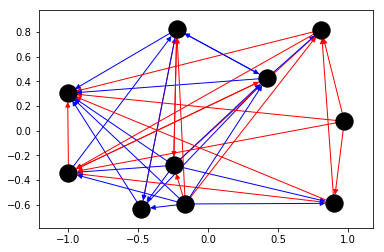

In [268]:
e=["red" if d['weight'] < 0 else "blue" for (u,v,d) in eco_g.edges(data=True)]

nx.draw_networkx(eco_g, node_color="black", edge_color=e, with_labels=False)

In [243]:
lex_g = nx.DiGraph()
lex_g = nx.from_dict_of_dicts(lex, create_using=lex_g)

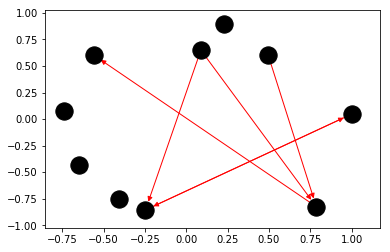

In [267]:
e=["red" if d['weight'] < 0 else "blue" for (u,v,d) in lex_g.edges(data=True)]

nx.draw_networkx(lex_g, node_color="black", edge_color=e, with_labels=False)

In [263]:
e

[-0.05000000000000002,
 -0.2,
 -0.15000000000000002,
 -0.2,
 -0.19999999999999998,
 -0.2]

OutEdgeView([((3, 1, 1, 3, 5), (4, 3, 2, 1, 5)), ((1, 6, 2, 1, 1), (1, 5, 4, 4, 1)), ((4, 3, 2, 1, 5), (3, 1, 1, 3, 5)), ((1, 5, 4, 4, 1), (1, 1, 4, 2, 1)), ((5, 1, 2, 5, 2), (4, 3, 2, 1, 5)), ((5, 1, 2, 5, 2), (1, 5, 4, 4, 1))])

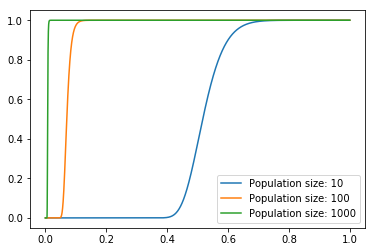

In [282]:
xvals = np.arange(0, 1, .0001)
y1 = (1 - (1-xvals)**10)**1000
y2 = (1 - (1-xvals)**100)**1000
y3 = (1 - (1-xvals)**1000)**1000
plt.plot(xvals, y1, label="Population size: 10")
plt.plot(xvals, y2, label="Population size: 100")
plt.plot(xvals, y3, label="Population size: 1000")
plt.legend()

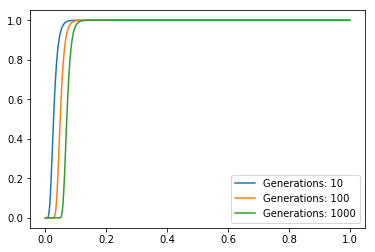

In [284]:
xvals = np.arange(0, 1, .0001)
y1 = (1 - (1-xvals)**100)**10
y2 = (1 - (1-xvals)**100)**100
y3 = (1 - (1-xvals)**100)**1000
plt.plot(xvals, y1, label="Generations: 10")
plt.plot(xvals, y2, label="Generations: 100")
plt.plot(xvals, y3, label="Generations: 1000")
plt.legend()